In [1]:
# silencing warnings
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

sns.set_theme(palette="Set2")

# CO2 concentration data

In [2]:
url = "https://github.com/PacktPublishing/Practical-Time-Series-Analysis/raw/master/Data%20Files/Monthly_CO2_Concentrations.xlsx"
df_co2 = pd.read_excel(url, converters={'Year': np.int32, 'Month': np.int32})
df_co2.head()

,CO2,Year,Month
0,333.13,1974,5
1,332.09,1974,6
2,331.10,1974,7
3,329.14,1974,8
4,327.36,1974,9


In [3]:
df_co2.shape

(174, 3)

In [4]:
df_co2.isnull().sum()

CO2      13
Year     13
Month    13
dtype: int64

In [5]:
df_co2.dropna(inplace=True)

<AxesSubplot:title={'center':'Monthly CO2 concentrations'}, xlabel='Time', ylabel='CO2 concentratition'>

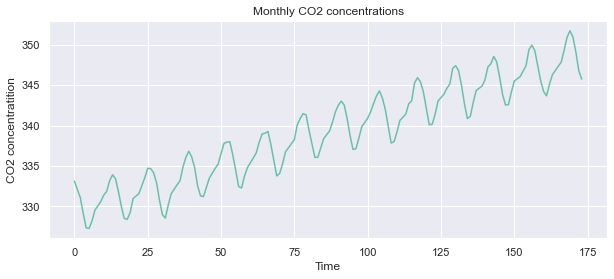

In [6]:
df_co2['CO2'].plot(xlabel="Time", ylabel="CO2 concentratition",
                   title="Monthly CO2 concentrations", figsize=(10, 4))

# Trend via Linear Regression

In [7]:
from sklearn.linear_model import LinearRegression

trend_model = LinearRegression(normalize=True, fit_intercept=True)
X = np.array(df_co2.index).reshape((-1,1))
y = df_co2['CO2']
trend_model.fit(X, y)
intercept = trend_model.intercept_
coef = trend_model.coef_[0]
print(f'Trend model intercept={intercept} coefficient={coef}')

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


Trend model intercept=329.4554222337018 coefficient=0.11182207854546689


In [8]:
df_co2['trendline'] = trend_model.predict(X)

<AxesSubplot:title={'center':'Monthly CO2 concentrations'}, xlabel='Time', ylabel='CO2 concentratition'>

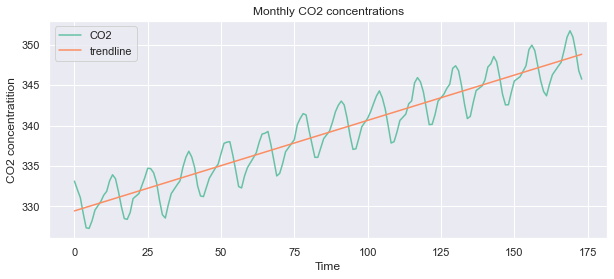

In [9]:
df_co2[['CO2', 'trendline']].plot(xlabel="Time", ylabel="CO2 concentratition",
                   title="Monthly CO2 concentrations", figsize=(10, 4))

In [10]:
df_co2['detrended'] = df_co2['CO2'] - df_co2['trendline']

<AxesSubplot:title={'center':'Detrended Monthly CO2 concentrations'}, xlabel='Time', ylabel='CO2 concentratition'>

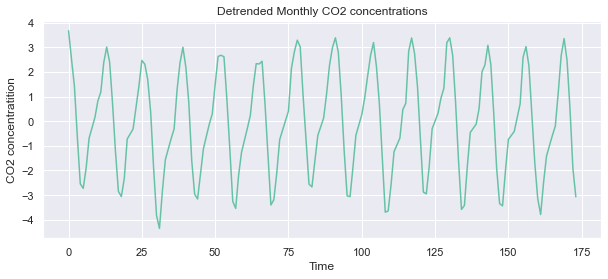

In [11]:
df_co2['detrended'].plot(xlabel="Time", ylabel="CO2 concentratition",
                   title="Detrended Monthly CO2 concentrations", figsize=(10, 4))

# Trend via moving average

<AxesSubplot:>

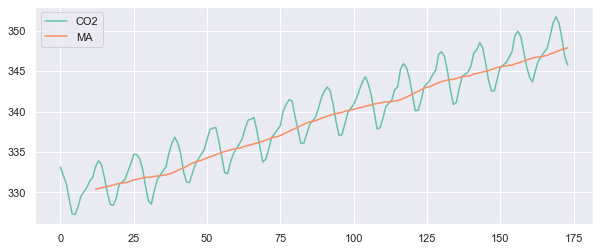

In [12]:
df_co2['MA'] = df_co2['CO2'].rolling(window=12).mean()
df_co2[['CO2', 'MA']].plot(figsize=(10, 4))

# Time series decomposition

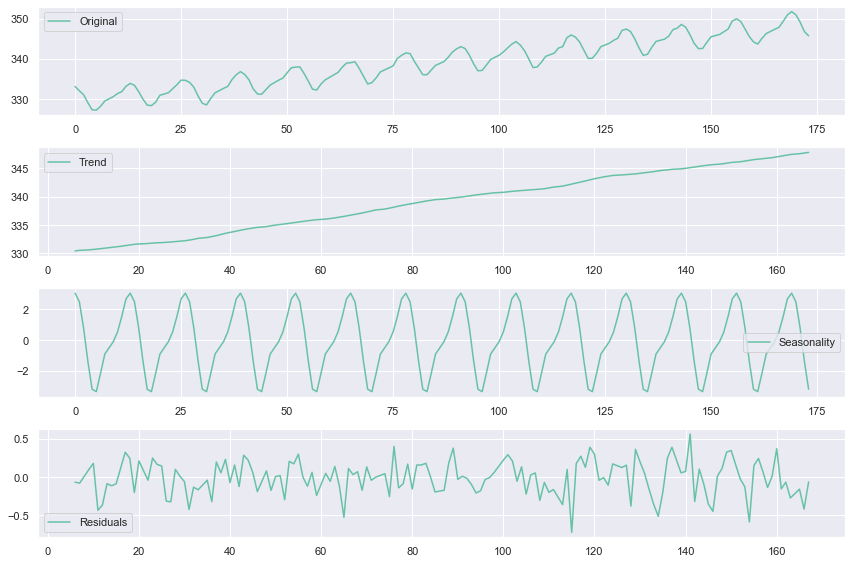

In [13]:
from statsmodels.tsa.seasonal import seasonal_decompose

# specify the number of observations in a cycle
decomposition = seasonal_decompose(df_co2['CO2'], freq=12)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(df_co2['CO2'], label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

# White noise and random walk

In [14]:
def random_walk(obs=100, d=1):
    """
    :param: obs: number of observations
    :param: d: number of dimensions
    """
    return np.cumsum(np.random.normal(0, 0.5, (obs, d)))

def white_noise(obs=100, d=1):
    return np.random.normal(0, 0.5, (obs, d)).flatten()

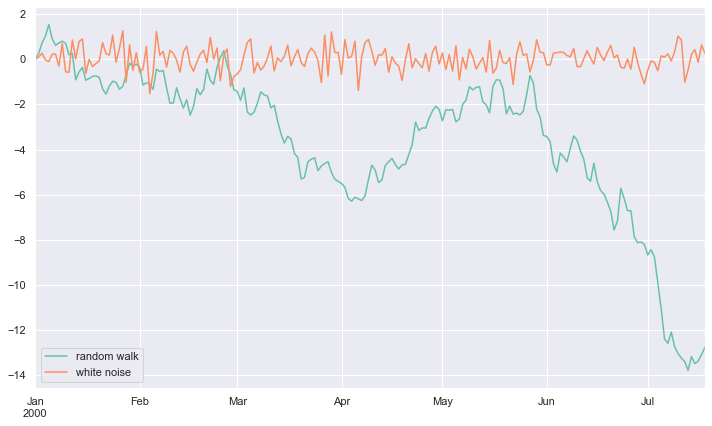

In [15]:
def build_graph(nobs=200):
    dts = pd.date_range(start="2000-01-01", periods=nobs)
    rw = pd.Series(random_walk(nobs), index=dts)
    wn = pd.Series(white_noise(nobs), index=dts)
    df = pd.concat([rw, wn], axis=1)
    df.columns = ["random walk", "white noise"]
    df.plot(figsize=(12, 7), use_index=True)

build_graph()

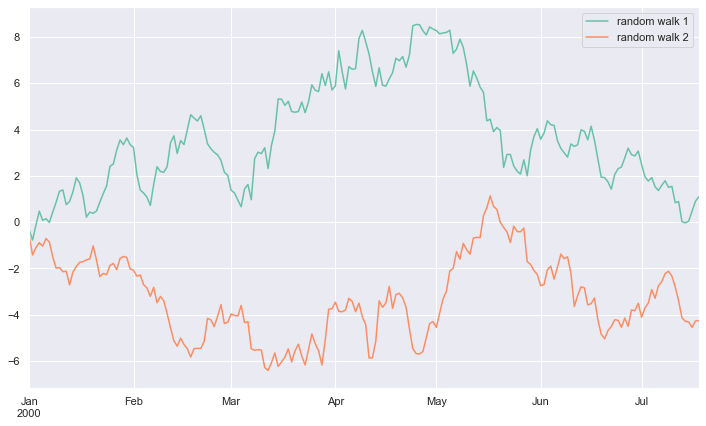

In [16]:
def two_rws(nobs=200):
    dts = pd.date_range(start="2000-01-01", periods=nobs)
    rw1 = pd.Series(random_walk(nobs), index=dts)
    rw2 = pd.Series(random_walk(nobs), index=dts)
    df = pd.concat([rw1, rw2], axis=1)
    df.columns = ["random walk 1", "random walk 2"]
    df.plot(figsize=(12, 7), use_index=True)

two_rws()

# Stationarity tests

Augmented Dickey-Fuller test, [documentation](https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html).

In [17]:
from statsmodels.tsa.stattools import adfuller

rw = random_walk(200)
wn = white_noise(200)

# use regression="nc" for statsmodels <=0.12.2 else regression="n"
adf_stat, pval, lags, obs, crit_vals, icbest = adfuller(rw, regression="nc")
print(f"ADF statistic: {adf_stat}")
print(f"p-value: {pval}")
print(f"Critical values: {crit_vals}")

ADF statistic: -0.5861710553597549
p-value: 0.4604055477680074
Critical values: {'1%': -2.5773010256410256, '5%': -1.9424617194490805, '10%': -1.6155259021224229}


In [18]:
adf_stat, pval, lags, obs, crit_vals, icbest = adfuller(wn, regression="nc")
print(f"ADF statistic: {adf_stat}")
print(f"p-value: {pval}")
print(f"Critical values: {crit_vals}")

ADF statistic: -5.761397570950046
p-value: 3.0068156910417956e-08
Critical values: {'1%': -2.577421827700072, '5%': -1.9424777047114803, '10%': -1.6155131670732337}


# Log transformation

<AxesSubplot:>

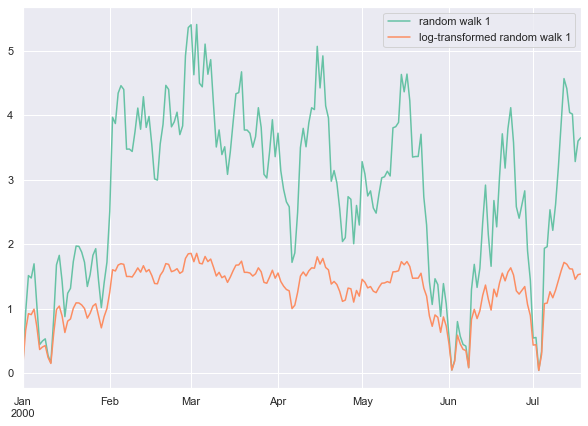

In [19]:
nobs = 200
dts = pd.date_range(start="2000-01-01", periods=nobs)
rw1 = pd.Series(abs(random_walk(nobs)), index=dts)
rw2 = pd.Series(np.log(rw1 + 1), index=dts)
df = pd.concat([rw1, rw2], axis=1)
df.columns = ["random walk 1", "log-transformed random walk 1"]
df.plot(figsize=(10, 7), use_index=True)

# Differencing

<AxesSubplot:>

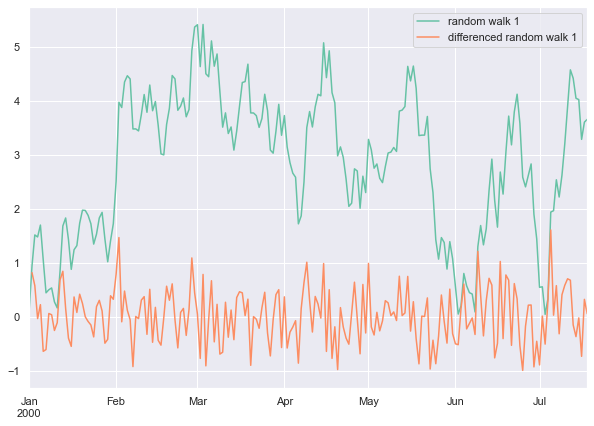

In [20]:
rw2 = pd.Series(rw1.diff().dropna(), index=dts)
df = pd.concat([rw1, rw2], axis=1)
df.columns = ["random walk 1", "differenced random walk 1"]
df.plot(figsize=(10, 7), use_index=True)

# Seasonal differencing

Because in the CO2 variable there appears to be seasonality, whose cycle equals one year, and there are monthly observations, we will subtract from each value the value located at 12 lags from it.

The first 12 values will be NaN, so we delete them.

In [21]:
detrended = df_co2['CO2'] - df_co2['trendline']

In [22]:
shifted = detrended.shift(12)[12:]

Similarly, delete the first 12 values from the original series.

In [23]:
shortened = detrended[12:]

<AxesSubplot:>

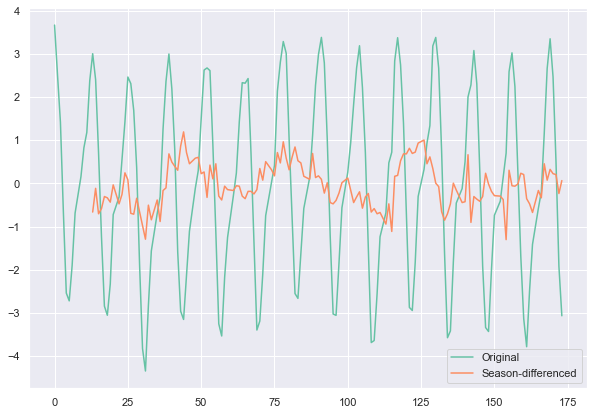

In [24]:
season_differenced = shortened - shifted

df = pd.concat([detrended, season_differenced], axis=1)
df.columns = ["Original", "Season-differenced"]
df.plot(figsize=(10, 7), use_index=True)

# Citing this notebook

If you use this notebook in your work, please cite it as follows:
    
Pekar, V. (2022). Big Data for Decision Making. Lecture examples and exercises. (Version 1.0.0). URL: https://github.com/vpekar/bd4dm
